# Byggingagreining á gervitunglamyndum
Nathan HK

In [2]:
from io import BytesIO
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pyrosm import OSM
from pyrosm import get_data
import pywikibot
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import sklearn as sk
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
mappa = '/Users/002-nathan/Desktop/Envalys/gtm/'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina byggingar á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar bygginga.
- **Gervitunglamyndir:** Við notum skjámyndatökur af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.
- **Staðsetningar bygginga:** Við notum OpenStreetMap.

Ég nota Apple M1 Pro-örgjörvi með 16 GB minni.

## Gervitunglamyndir
Við notum lista yfir greinar á ensku Wikipediunni um staði á Höfuðborgarsvæðinu og Akureyri. Gögnin á Landsbyggðinni eru ekki nóg nákvæm fyrir þetta líkan.

In [4]:
byrjun = time.time()
hnitlisti = []
wiki = pywikibot.Site('en', 'wikipedia')

# Capital Region
flokkur_h = pywikibot.Category(wiki, 'Populated places in Capital Region (Iceland)')
undir = list(flokkur_h.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('h', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('h', len(hnitlisti), time.time() - byrjun)

# Akureyri
flokkur_a = pywikibot.Category(wiki, 'Akureyri')
undir = list(flokkur_a.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('a', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('a', len(hnitlisti), time.time() - byrjun)

54
h 120 100.04301071166992
6
a 130 115.1063187122345


Við getum ekki tekið myndir af miðjunni skjásins, því það eru önnur HTML-efni sem hylja gervitunglamyndirnar. Þess vegna leitum við að staði sem eru 0.002° til austurs frá myndatökustaðnum; hérna eru hnitin á skjánum fyrir þennan stað.

In [5]:
skhn = (746, 861)

Við tökum skjámyndir af öllum stöðum á hnitlistanum.
- URL-ið notar ISN93-hnit, en okkar hnit eru WGS84, og það er engin einföld leið til að skipta milli þeirra. Þess vegna þurfum við að leita að hnitum eins og manneskja myndi leita.
- Á Chrome er myndasvæðið 512x512, en þegar myndin er vistuð verður hún 1024x1024.

In [6]:
byrjun = time.time()
driver = webdriver.Chrome()
driver.set_window_size(1500, 1000)
driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
# Accept GDPR
try:
    btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
    btn.click()
except NoSuchElementException:
    pass
# Allow cookies
try:
    btn = driver.find_element(By.XPATH, '//button[@class="ch2-btn ch2-allow-all-btn ch2-btn-primary"]')
    btn.click()
except NoSuchElementException:
    pass
leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
for n in range(len(hnitlisti)):
    if n % 50 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Input search term into search box
    try:
        z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
        z.close()
    except FileNotFoundError:
        leit.clear()
        leit.send_keys(str(hnit[1]) + ', ' + str(hnit[2] + 0.002))
        leit.send_keys(Keys.RETURN)
        time.sleep(2) # Wait for images to load
        try:  # Place not found
            nf = driver.find_element(By.XPATH, '//div[@class="row not-found"]')
        except NoSuchElementException:  # Place found, save and crop screenshot
            driver.save_screenshot(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
            skmynd.save(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        time.sleep(1)
driver.close()
print(time.time() - byrjun)

0 4.565173149108887
50 4.568786144256592
100 4.573569059371948
4.649569034576416


## Staðsetningar bygginga
Við sækjum gögn frá OpenStreetMap.

In [7]:
fp = get_data('Iceland')

Þetta undirforrit tekur díl á myndinni og finnur GPS-hnitin. Við notum Web Mercator.

In [8]:
def pix2coord(pix, hnit_br):
    x_t = hnit_br[1] + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = hnit_br[0] + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

Þetta undirforrit tekur GPS-hnit og finnur dílinn á myndinni. Forritað með aðstoð frá o1-preview eftir OpenAI.

In [9]:
def coord2pix(lat, lon, hnit_br):
    # Convert degrees to radians
    lon_radians = math.radians(lon)
    lat_radians = math.radians(lat)
    
    # Invert the calculation for x_t
    x_t = ((lon_radians + math.pi) * (2 ** 17)) / (2 * math.pi)
    # Calculate pix[0] (x-coordinate)
    pix_x = (x_t - hnit_br[1]) * 1024 + 512
    
    # Invert the calculation for y_t
    b = lat_radians / 2 + math.pi / 4
    a = math.tan(b)
    c = math.pi - math.log(a)
    y_t = c * (2 ** 17) / (2 * math.pi)
    # Calculate pix[1] (y-coordinate)
    pix_y = (y_t - hnit_br[0]) * 1024 + 512
    
    return (pix_x, pix_y)

Við sækjum tvo lista: einn yfir byggingar á Höfuðborgarsvæðinu, og einn á Akureyri.

In [10]:
byrjun = time.time()
byg_listi = {}
osm_h = OSM(fp, bounding_box=[-22.140901, 63.847886, -21.152576, 64.390306])
byg_listi['h'] = osm_h.get_buildings()
osm_a = OSM(fp, bounding_box=[-18.398071, 65.543087, -17.968359, 66.576398])
byg_listi['a'] = osm_a.get_buildings()
print(time.time() - byrjun)

25.62529492378235


Fyrir hverja skjámynd búum við til tvívíddarlista sem sýnir staðsetningar bygginga. Dílar með byggingum eru rauðir, og dílar án bygginga eru bláir.

In [11]:
byrjun = time.time()
X_gogn = []
y_gogn = []
bd_all = {}
for st in ['h', 'a']:
    byggingar = byg_listi[st]
    bd = []
    for k in range(byggingar.shape[0]):
        bns = byggingar['geometry'][k].bounds
        bd.append(bns)
    bd_all[st] = bd
for n in range(len(hnitlisti)):
    if n % 10 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Open image
    try:
        gtm = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        dilar = gtm.load()
    except FileNotFoundError:
        continue
    X_gogn.append(torch.tensor(np.transpose(np.array(gtm.getdata()).reshape(1024, 1024, 3), 
                                            (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device))
    # Convert coordinates
    y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) - 0.5
    y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) + 0.5
    byggingar = byg_listi[hnit[0]]
    hnit_br = (1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))),
               1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[2])))
    # Buildings
    y_mynd = np.zeros((1, 1, 1024, 1024))
    bd = bd_all[hnit[0]]
    for k in range(byggingar.shape[0]):
        bns = bd[k]
        if bns[0] > hnit[2] + 0.0014 or bns[1] > hnit[1] + 0.0008 or bns[2] < hnit[2] - 0.0014 or bns[3] < hnit[1] - 0.0008:
            continue
        NW = coord2pix(bns[3], bns[0], hnit_br)
        SE = coord2pix(bns[1], bns[2], hnit_br)
        if NW[0] > 1024 or NW[1] > 1024 or SE[0] < 0 or SE[1] < 0:
            continue
        for i in range(max(0, int(NW[0])), min(1024, int(SE[0]) + 1)):
            for j in range(max(0, int(NW[1])), min(1024, int(SE[1]) + 1)):
                if y_mynd[0][0][i][j] == 1:
                    continue
                coord = pix2coord((i, j), hnit_br)
                if byggingar['geometry'][k].contains(Point(coord[1], coord[0])):
                    y_mynd[0][0][i][j] = 1
                    gtm.putpixel((i, j), (max(dilar[i,j][0] + 64, 255), dilar[i,j][1], dilar[i,j][2]))
    gtm.save(mappa + 'saman_' + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
    y_gogn.append(torch.tensor(y_mynd, dtype=torch.float32).to(device))
print(time.time() - byrjun)

0 0.5127067565917969
10 78.11082291603088
20 150.23039484024048
30 242.769917011261
40 364.7408399581909
50 432.21098494529724
60 509.72645378112793
70 557.8350780010223
80 601.4616889953613
90 712.3754439353943
100 858.148148059845
110 926.4363679885864
120 1019.4910380840302
1069.4642729759216


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_gogn, y_gogn)

## Líkan
Hérna er U-Net til að greina díla á gervitunglamyndum. Forritað með aðstoð frá o1-preview.

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoding path
        self.enc1 = self.contract_block(in_channels, 64, 7, 3)
        self.enc2 = self.contract_block(64, 128, 3, 1)
        self.enc3 = self.contract_block(128, 256, 3, 1)
        self.enc4 = self.contract_block(256, 512, 3, 1)
        self.enc5 = self.contract_block(512, 1024, 3, 1)

        # Decoding path
        self.dec5 = self.expand_block(1024, 512, 3, 1)
        self.dec4 = self.expand_block(1024, 256, 3, 1)
        self.dec3 = self.expand_block(512, 128, 3, 1)
        self.dec2 = self.expand_block(256, 64, 3, 1)
        self.dec1 = self.final_block(128, out_channels, 3, 1)

    def __call__(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        enc5 = self.enc5(F.max_pool2d(enc4, kernel_size=2))

        # Decoding path
        dec5 = self.dec5(F.interpolate(enc5, scale_factor=2, mode='bilinear', align_corners=True))
        dec5 = torch.cat((enc4, dec5), dim=1)
        dec4 = self.dec4(F.interpolate(dec5, scale_factor=2, mode='bilinear', align_corners=True))
        dec4 = torch.cat((enc3, dec4), dim=1)
        dec3 = self.dec3(F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=True))
        dec3 = torch.cat((enc2, dec3), dim=1)
        dec2 = self.dec2(F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True))
        dec2 = torch.cat((enc1, dec2), dim=1)
        dec1 = self.dec1(dec2)

        return dec1  # Output logits

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        return expand

    def final_block(self, in_channels, out_channels, kernel_size, padding):
        final = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.Sigmoid()  # Use sigmoid activation for binary classification
        )
        return final

In [14]:
epochs = 10
thresh = 0.5

In [16]:
byrjun = time.time()
train_prs = []
test_prs = []
train_rec = []
test_rec = []
likan = UNet(in_channels=3, out_channels=1)
likan.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(likan.parameters(), lr=1e-4)
for e in range(epochs):
    # Evaluate accuracy
    print(e, 'train', time.time() - byrjun)
    likan.eval()
    with torch.no_grad():
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(X_train)):
            y_pred = likan(X_train[i])
            frum = y_train[i].bool()
            nid = (y_pred >= thresh)
            tp += (nid & frum).sum().item()
            fp += (nid & ~frum).sum().item()
            fn += (~nid & frum).sum().item()
        train_prs.append(tp / (tp + fp))
        train_rec.append(tp / (tp + fn))
        print(e, 'test', time.time() - byrjun)
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(X_test)):
            y_pred = likan(X_test[i])
            frum = y_test[i].bool()
            nid = (y_pred >= thresh)
            tp += (nid & frum).sum().item()
            fp += (nid & ~frum).sum().item()
            fn += (~nid & frum).sum().item()
        test_prs.append(tp / (tp + fp))
        test_rec.append(tp / (tp + fn))
    # Train model
    likan.train()
    for i in range(len(X_train)):
        if i % 10 == 0:
            print(e, i, time.time() - byrjun)
        optimizer.zero_grad()
        y_pred = likan(X_train[i])
        loss = criterion(y_pred, y_train[i])
        loss.backward()
        optimizer.step()
        torch.mps.synchronize()
# Evaluate accuracy
print(epochs, 'train', time.time() - byrjun)
likan.eval()
with torch.no_grad():
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(X_train)):
        if i % 10 == 0:
            print(e, 'train', i, time.time() - byrjun)
        y_pred = likan(X_train[i])
        frum = y_train[i].bool()
        nid = (y_pred >= thresh)
        tp += (nid & frum).sum().item()
        fp += (nid & ~frum).sum().item()
        fn += (~nid & frum).sum().item()
    train_prs.append(tp / (tp + fp))
    train_rec.append(tp / (tp + fn))
    print(epochs, 'test', time.time() - byrjun)
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(X_test)):
        if i % 10 == 0:
            print(e, 'test', i, time.time() - byrjun)
        y_pred = likan(X_test[i])
        frum = y_test[i].bool()
        nid = (y_pred >= thresh)
        tp += (nid & frum).sum().item()
        fp += (nid & ~frum).sum().item()
        fn += (~nid & frum).sum().item()
    test_prs.append(tp / (tp + fp))
    test_rec.append(tp / (tp + fn))
print(time.time() - byrjun)

0 train 0.5152199268341064
0 test 103.53660297393799
0 0 138.11367392539978
0 10 250.24990797042847
0 20 359.8759949207306
0 30 474.15410804748535
0 40 575.7442281246185
0 50 683.0803380012512
0 60 792.4788680076599
0 70 904.2430331707001
0 80 1013.3565590381622
0 90 1112.740287065506
1 train 1178.279205083847
1 test 1276.7699398994446
1 0 1309.4478709697723
1 10 1405.6863098144531
1 20 1494.3983838558197
1 30 1583.8091390132904
1 40 1668.0419800281525
1 50 1754.9381790161133
1 60 1852.416335105896
1 70 1950.081171989441
1 80 2084.7542588710785
1 90 2197.1646139621735
2 train 2272.884314060211
2 test 2373.6345059871674
2 0 2406.041156053543
2 10 2501.101914167404
2 20 2589.9245450496674
2 30 2679.5449380874634
2 40 2762.4407811164856
2 50 2853.126370191574
2 60 2942.17902803421
2 70 3037.7843329906464
2 80 3134.779543161392
2 90 3230.6768231391907
3 train 3291.210396051407
3 test 3392.36021900177
3 0 3424.7605361938477
3 10 3514.650801897049
3 20 3605.6701040267944
3 30 3693.9324338436

## Mat

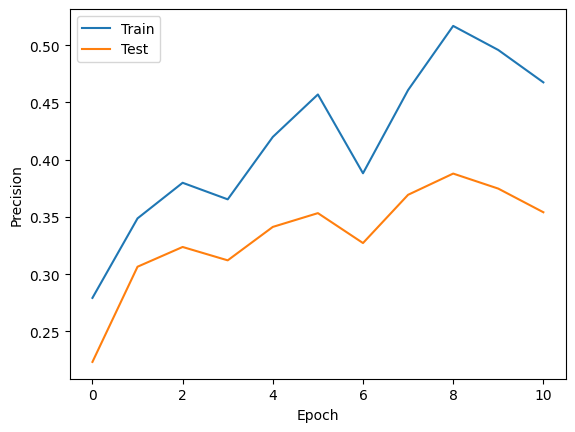

In [17]:
plt.plot(train_prs, label='Train')
plt.plot(test_prs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

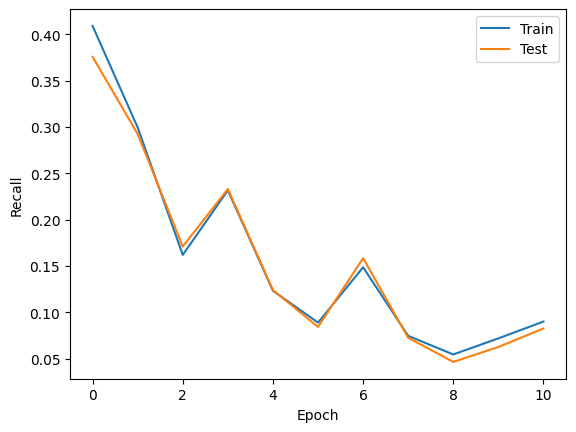

In [18]:
plt.plot(train_rec, label='Train')
plt.plot(test_rec, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

## Lokaorð
Greiningin gekk illa. Líkanið er alls ekki nógu nákvæmt fyrir eiginlega notkun.

Hvert förum við héðan?
- Við reynum að greina marghyrninga heldur en díla. Við getum búið til greypingu (e. *embedding*) fyrir hverja byggingu.
- Við fáum betri gervitunglamyndir. Á þeim sem við notum núna eru byggingarnar hallaðar, og hnitin eru oft ekki nógu nákvæm.